In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import pandas as pd
import sys
import os

# Linux下添加此代码(即添加临时模块搜索路径);当前项目路径为默认模块搜索路径(仅pycharm中)
sys.path.append(os.path.abspath(".." + os.sep + ".." + os.sep + ".."))

from text_classification.utils.train_evaluate import Trainer
from text_classification.models.TextGRU import TextGRU
from text_classification.data_ag_news.data.data_process_glove import DataProcess

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dp = DataProcess('../datasets/train.csv', '../datasets/test.csv', device, 512)
train_loader, test_loader = dp.get_dataLoader(141)
pre_vector = dp.get_pre_trained("glove.6B.50d.txt", '../../extra/glove_vector/')
print(pre_vector.shape)

torch.Size([95812, 50])


In [3]:
model = TextGRU(num_class=4, vocab_size=pre_vector.shape[0], embedding_size=pre_vector.shape[1],
                hidden_size=256, num_layers=2, dropout_ratio=0.3, bidirectional=True)
# 使用模型预训练词向量矩阵
model.embed.weight.data.copy_(pre_vector)
model.embed.weight.requires_grad = False  # 冻结网络层,使之不参与训练
model = model.to(device)

epochs = 20
lr = 0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

In [4]:
def compute_metrics_f1(predict_all, y_true):
    """f1 score评估函数"""
    predict = predict_all.argmax(-1)
    label = y_true
    acc = f1_score(label, predict, average='micro')
    return {"f1": acc}


t_and_v = Trainer(model=model, optimizer=optimizer, criterion=criterion, epochs=epochs)

metric_result = t_and_v.train(train_loader=train_loader, valid_loader=test_loader,
                              compute_metrics=compute_metrics_f1, verbose=100)
metric_result_df = pd.DataFrame(metric_result)
metric_result_df.index.name = 'epoch'
metric_result_df

Train Epoch: 0  [0    /120000 (0  %)]	Loss: 1.382480	f1: 0.271484
Train Epoch: 0  [51200/120000 (43 %)]	Loss: 1.326409	f1: 0.589844
Train Epoch: 0  [102400/120000 (85 %)]	Loss: 1.255347	f1: 0.654297
Train Epoch: 0  [120000/120000 (100%)]	Loss: 1.222780	f1: 0.661458
----------------------------------------------------------------------------------------------------
Train Epoch: 1  [0    /120000 (0  %)]	Loss: 1.214716	f1: 0.697266
Train Epoch: 1  [51200/120000 (43 %)]	Loss: 1.103358	f1: 0.677734
Train Epoch: 1  [102400/120000 (85 %)]	Loss: 0.942266	f1: 0.712891
Train Epoch: 1  [120000/120000 (100%)]	Loss: 0.884369	f1: 0.708333
----------------------------------------------------------------------------------------------------
Train Epoch: 2  [0    /120000 (0  %)]	Loss: 0.874779	f1: 0.775391
Train Epoch: 2  [51200/120000 (43 %)]	Loss: 0.780696	f1: 0.769531
Train Epoch: 2  [102400/120000 (85 %)]	Loss: 0.762797	f1: 0.740234
Train Epoch: 2  [120000/120000 (100%)]	Loss: 0.653490	f1: 0.765625


,Training loss,Training f1,Validation loss,Validation f1
epoch,,,,
0,1.207212,0.730783,1.209387,0.723421
1,0.871655,0.761767,0.878661,0.759605
2,0.660005,0.787200,0.670322,0.784342
3,0.571653,0.802683,0.582672,0.802237
4,0.521429,0.816533,0.531413,0.815921
5,0.488759,0.827692,0.497551,0.827500
6,0.462193,0.836467,0.470360,0.834079
7,0.438485,0.845108,0.446849,0.843026
8,0.419435,0.852092,0.428027,0.851447


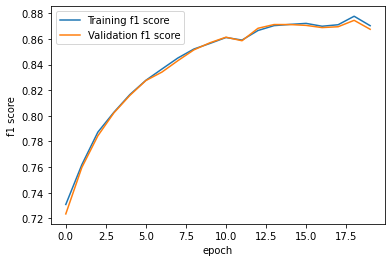

In [5]:
plt.plot(metric_result['Training f1'], label='Training f1 score')
plt.plot(metric_result['Validation f1'], label='Validation f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend()
plt.show()